In [ ]:
!pip install pymorphy3 gensim seaborn navec slovnet -q
!pip install "scipy<1.13.0" "numpy<2.0" "gensim==4.3.2" -q

# после скачивания нужно перезапустить ноутбук (для w2v модели)

In [48]:
import re
from tqdm import tqdm
from tqdm.auto import tqdm
tqdm.pandas()

import pandas as pd
import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

from transformers import BertModel, BertTokenizer

from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.normalizers import Lowercase
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import BertPreTokenizer, CharDelimiterSplit

import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import pymorphy3
from gensim.models import Word2Vec
from navec import Navec
from slovnet.model.emb import NavecEmbedding

nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\username\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\username\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [49]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [4]:
from zipfile import ZipFile
with ZipFile('dl-2025-study-competition-2.zip') as zf:
    zf.extractall()

# Загрузка данных

In [50]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.shape, test_data.shape

((29568, 3), (7392, 2))

In [60]:
train_data = train_data[train_data.text.duplicated() == False]

In [61]:
train_data.head()

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0


In [62]:
train_data.tail()

,id,text,labels
29562,29562,Атмосферный концерт «Моцарт при свечах. Ночь в...,0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


In [63]:
train_data.sample(5)

,id,text,labels
26894,26894,Дополнили подборку\nеще 2 бесплатными спортивн...,1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1
28595,28595,Скидка 20% по промокоду SYHOYZ на спектакль “П...,0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0
11515,11515,"ЭЛЬБРУС\n""Подъемлясь к небу величаво,\nГора из...",1 1 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0
3226,3226,Коротко о погоде в Ростове\n🔥\n🔴\nПодписаться ...,0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1
1088,1088,Самая драконистая Ёлка 2024 ждет смелых карапу...,1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0


In [64]:
test_data.head()

,id,text
0,29568,"ЭЙ, ВЛЮБЛЁННЫЕ\nСкидка 20% промокоду SYHOYZ\nн..."
1,29569,Пруды Москвы
2,29570,🤪\n🤪\n👏\n👏\n😄\n😄\n👏\n👏\n👨‍👩‍👦\nСемейка лёгкого...
3,29571,24 СЕНТЯБРЯ\nИсторический фестиваль «Башкирия ...
4,29572,19-20 августа\nДетский клуб в кафе «Отдых»\nТе...


In [65]:
train_labels = train_data['labels'].apply(lambda a: list(map(int, a.split())))
train_labels = torch.Tensor(train_labels)

In [66]:
# Веса для BCEWithLogitsLoss
pos_counts = train_labels.sum(axis=0)
neg_counts = train_labels.size(0) - pos_counts
pos_weight = neg_counts / pos_counts
pos_weight = pos_weight.to(DEVICE)
pos_weight

tensor([8.4402e-01, 5.4610e-01, 1.8887e+01, 1.5667e+01, 6.2648e-01, 2.7991e+02,
        1.3945e+02, 2.9774e-01, 2.7281e-01, 4.3709e-01, 1.3172e+00, 5.9116e-01,
        2.6410e-01, 2.8672e-01, 3.1604e-01, 9.9637e-01, 3.5445e-01, 2.5189e-01,
        2.1555e-01, 4.1582e+00], device='cuda:0')

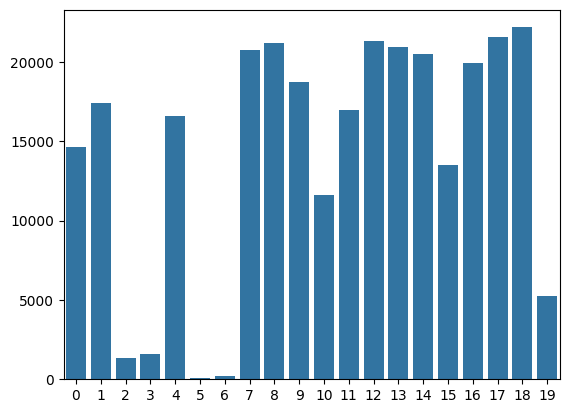

In [67]:
sns.barplot(train_labels.sum(axis=0))
plt.show()

# Обработка текста

In [68]:
def text_preprocessing(text, tokenize=True, normalize=False):
    NONWORDS_PATTERN = r'[^а-яё\s]'
    LINKS_PATTERN = r'https?://.+?(?=\s|$)'

    processed = text.apply(lambda t: t.lower()) # приводим к нижнему регистру
    processed = processed.apply(lambda t: re.sub(LINKS_PATTERN, '', t)) # удаляем ссылки
    processed = processed.apply(lambda t: re.sub(NONWORDS_PATTERN, '', t)) # удаляем небуквенные символы
    processed = processed.apply(lambda t: re.sub(r'\s+', ' ', t)) # заменяем множественные пробелы на единичные

    tokens = []
    normal_tokens = []

    if tokenize:
        tokens = processed.apply(lambda t: word_tokenize(t)) # разбиение на токены (слова)
        tokens = tokens.progress_apply(lambda s: list(filter(lambda t: t not in stopwords.words('russian'), s)))
        tokens = list(map(lambda s: list(filter(lambda t: len(t) > 3, s)), tokens))
        if normalize:
            normal_tokens = []
            morph = pymorphy3.MorphAnalyzer()

            for doc in tqdm(tokens):
                normal_forms = list(map(lambda w: morph.parse(w)[0].normal_form, doc))
                normal_tokens.append(normal_forms)

    return processed, tokens, normal_tokens

In [69]:
train_text, val_text, train_labels, val_labels = train_test_split(train_data.text, train_labels, test_size=0.3, random_state=42)

In [70]:
train_processed, train_tokens, train_normal = text_preprocessing(train_text, tokenize=True, normalize=True)
val_processed, val_tokens, val_normal = text_preprocessing(val_text, tokenize=True, normalize=True)

  0%|          | 0/18876 [00:00<?, ?it/s]

  0%|          | 0/18876 [00:00<?, ?it/s]

  0%|          | 0/8091 [00:00<?, ?it/s]

  0%|          | 0/8091 [00:00<?, ?it/s]

In [71]:
test_processed, test_tokens, test_normal = text_preprocessing(test_data.text, tokenize=True, normalize=True)

  0%|          | 0/7392 [00:00<?, ?it/s]

  0%|          | 0/7392 [00:00<?, ?it/s]

In [72]:
import pickle

train_data = (train_processed, train_tokens, train_normal)

with open('train_data.pickle', 'wb') as file:
    pickle.dump(train_data, file)

val_data = (val_processed, val_tokens, val_normal)

with open('val_data.pickle', 'wb') as file:
    pickle.dump(val_data, file)

test_data = (test_processed, test_tokens, test_normal)

with open('test_data.pickle', 'wb') as file:
    pickle.dump(test_data, file)

In [73]:
import pickle

with open('train_data.pickle', 'rb') as file:
    loaded_data = pickle.load(file)

train_processed, train_tokens, train_normal = loaded_data

with open('val_data.pickle', 'rb') as file:
    loaded_data = pickle.load(file)

val_processed, val_tokens, val_normal = loaded_data

with open('test_data.pickle', 'rb') as file:
    loaded_data = pickle.load(file)

test_processed, test_tokens, test_normal = loaded_data

In [74]:
train_normal_sent = list(map(lambda t: " ".join(t), train_normal))
val_normal_sent = list(map(lambda t: " ".join(t), val_normal))
test_normal_sent = list(map(lambda t: " ".join(t), test_normal))

train_tokens_sent = list(map(lambda t: " ".join(t), train_tokens))
val_tokens_sent = list(map(lambda t: " ".join(t), val_tokens))

In [75]:
mean_count_tokens = np.mean(list(map(len, train_normal)))

# Функции для обучения модели

In [76]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [77]:
WARMUP_STEPS = 1

def lr_lambda(step): # WarmUp
    if step < WARMUP_STEPS:
        return (step + 1) / WARMUP_STEPS
    return 1.0

In [78]:
class Trainer():
    def __init__(self, model,
                 lr=1e-3, weight_decay=1e-4,
                 patience=5, n_epoch=10,
                 print_every=2, verbose_every=500, pos_weight=None):
        self.model = model
        self.loss = nn.BCEWithLogitsLoss()

        trainable_params = list(filter(lambda p: p.requires_grad, self.model.parameters()))
        self.optimizer = optim.Adam(trainable_params, lr=lr, weight_decay=weight_decay)
        # self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda)
        self.scheduler = None
        self.early_stopper = EarlyStopping(patience=patience)

        self.n_epoch = n_epoch
        self.print_every = print_every
        self.verbose_every = verbose_every

        self.losses = {'train': [], 'val': []}
        self.metrics = {'train': [], 'val': []}

    def train(self, train_dataloader, val_dataloader):
        verbose = False
        for epoch in range(self.n_epoch + 1):
            if self.print_every is not None and epoch % self.print_every == 0:
                print(f'EPOCH {epoch}\n---------------')
                verbose = self.verbose_every
            else:
                verbose = False

            train_res = self.train_loop(train_dataloader, verbose)
            val_res = self.eval_loop(val_dataloader, verbose)

            self.losses['train'].append(train_res[0])
            self.losses['val'].append(val_res[0])

            self.metrics['train'].append(train_res[1])
            self.metrics['val'].append(val_res[1])
            if self.scheduler:
                self.scheduler.step()

            self.early_stopper(val_res[0])
            if self.early_stopper.early_stop:
                print(f'Loss stopped improving. Terminating training.')
                break

    def train_loop(self, dataloader, verbose=False):
        self.model.train()
        epoch_loss = 0

        ground_truth = []
        predictions = []

        for idx, (X, y) in enumerate(dataloader):
            predict_logits = self.model(X)
            batch_loss = self.loss(predict_logits, y.float())

            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()

            epoch_loss += batch_loss.item()

            ground_truth.extend(y.tolist())
            predict_class = (predict_logits > 0.5).int()
            predictions.extend(predict_class.tolist())

            if verbose and idx % verbose == 0:
                print(f'Loss: {round(batch_loss.item(), 5)}')

        epoch_loss /= len(dataloader)
        f1 = f1_score(ground_truth, predictions, average="macro")

        if verbose:
            print(f'Train Loss: {round(epoch_loss, 5)}\t Train Macro F1: {round(f1, 5)}')

        return epoch_loss, f1, ground_truth, predictions

    def eval_loop(self, dataloader, verbose=False):
        self.model.eval()
        epoch_loss = 0

        ground_truth = []
        predictions = []

        with torch.no_grad():
            for idx, (X, y) in enumerate(dataloader):
                predict_logits = self.model(X)
                batch_loss = self.loss(predict_logits, y.float())
                epoch_loss += batch_loss.item()

                ground_truth.extend(y.tolist())
                predict_class = (predict_logits > 0.5).int()
                predictions.extend(predict_class.tolist())

        epoch_loss /= len(dataloader)
        f1 = f1_score(ground_truth, predictions, average="macro")

        if verbose:
            print(f'Val Loss: {round(epoch_loss, 5)}\t Val Macro F1: {round(f1, 5)}\n')

        return epoch_loss, f1, ground_truth, predictions

    def visualize(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
        colors = plt.get_cmap('tab10').colors

        axes[0].plot(self.losses['train'], label='Train Loss', color=colors[0], linewidth=2.5)
        axes[0].plot(self.losses['val'], label='Val Loss', color=colors[1], linewidth=2.5, linestyle='--')

        axes[0].set_title('Loss per Epoch', fontsize=14)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].grid(alpha=0.3)
        axes[0].legend(fontsize=10)
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['right'].set_visible(False)


        axes[0].annotate(f"{self.losses['val'][-1]:.4f}",
                        xy=(len(self.losses['val']) - 1, self.losses['val'][-1]),
                        xytext=(-30, 10), textcoords='offset points',
                        fontsize=10, color=colors[1],
                        arrowprops=dict(arrowstyle='->', color=colors[1]))


        axes[1].plot(self.metrics['train'], label='Train F1', color=colors[2], linewidth=2.5)
        axes[1].plot(self.metrics['val'], label='Val F1', color=colors[3], linewidth=2.5, linestyle='--')

        axes[1].set_title('F1-Score per Epoch', fontsize=14)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('F1-Score', fontsize=12)
        axes[1].grid(alpha=0.3)
        axes[1].legend(fontsize=10)
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)

        axes[1].annotate(f"{self.metrics['val'][-1]:.4f}",
                        xy=(len(self.metrics['val']) - 1, self.metrics['val'][-1]),
                        xytext=(-30, 10), textcoords='offset points',
                        fontsize=10, color=colors[3],
                        arrowprops=dict(arrowstyle='->', color=colors[3]))

        plt.tight_layout()
        plt.show()

# TF-IDF + Нейронная сеть

In [79]:
vectorizer = TfidfVectorizer(stop_words=stopwords.words('russian'), tokenizer=word_tokenize, min_df=10/len(train_text))
vectorizer.fit(train_normal_sent)

vectorizer.get_feature_names_out()

C:\Users\username\Python3.12\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


array(['абобров', 'абобровдбелоцерковский', 'абонемент', ..., 'ёлка',
       'ёлочка', 'ёлочный'], dtype=object)

In [80]:
class TfIDF_Dataset(Dataset):
    def __init__(self, text, labels, vectorizer):
        super(TfIDF_Dataset, self).__init__()
        self.text = text
        self.labels = labels
        self.vectorizer = vectorizer

    def __getitem__(self, idx):
        text = self.text[idx]

        if self.labels is not None:
            labels = self.labels[idx]
            return text.float().to(DEVICE), labels.float().to(DEVICE)
        else:
            return text.float().to(DEVICE)

    def __len__(self):
        return len(self.text)

In [81]:
train_X = vectorizer.transform(train_normal_sent).toarray()
val_X = vectorizer.transform(val_normal_sent).toarray()

In [82]:
train_dataset = TfIDF_Dataset(torch.tensor(train_X), train_labels, vectorizer)
val_dataset = TfIDF_Dataset(torch.tensor(val_X), val_labels, vectorizer)
train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [83]:
WARMUP_STEPS = 3

## tf-IDF модель

In [84]:
class Trainer_for_tf_idf():
    def __init__(self, model,
                 lr=1e-3, weight_decay=1e-4,
                 patience=5, n_epoch=10,
                 print_every=2, verbose_every=500, pos_weight=None):
        self.model = model
        self.loss = nn.BCELoss()

        trainable_params = list(filter(lambda p: p.requires_grad, self.model.parameters()))
        self.optimizer = optim.Adam(trainable_params, lr=lr, weight_decay=weight_decay)
        # self.scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer, lr_lambda)
        self.scheduler = None
        self.early_stopper = EarlyStopping(patience=patience)

        self.n_epoch = n_epoch
        self.print_every = print_every
        self.verbose_every = verbose_every

        self.losses = {'train': [], 'val': []}
        self.metrics = {'train': [], 'val': []}

    def train(self, train_dataloader, val_dataloader):
        verbose = False
        for epoch in range(self.n_epoch + 1):
            if self.print_every is not None and epoch % self.print_every == 0:
                print(f'EPOCH {epoch}\n---------------')
                verbose = self.verbose_every
            else:
                verbose = False

            train_res = self.train_loop(train_dataloader, verbose)
            val_res = self.eval_loop(val_dataloader, verbose)

            self.losses['train'].append(train_res[0])
            self.losses['val'].append(val_res[0])

            self.metrics['train'].append(train_res[1])
            self.metrics['val'].append(val_res[1])
            if self.scheduler:
                self.scheduler.step()

            self.early_stopper(val_res[0])
            if self.early_stopper.early_stop:
                print(f'Loss stopped improving. Terminating training.')
                break

    def train_loop(self, dataloader, verbose=False):
        self.model.train()
        epoch_loss = 0

        ground_truth = []
        predictions = []

        for idx, (X, y) in enumerate(dataloader):
            predict_logits = self.model(X)
            batch_loss = self.loss(predict_logits, y.float())

            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()

            epoch_loss += batch_loss.item()

            ground_truth.extend(y.tolist())
            predict_class = (predict_logits > 0.5).int()
            predictions.extend(predict_class.tolist())

            if verbose and idx % verbose == 0:
                print(f'Loss: {round(batch_loss.item(), 5)}')

        epoch_loss /= len(dataloader)
        f1 = f1_score(ground_truth, predictions, average="macro")

        if verbose:
            print(f'Train Loss: {round(epoch_loss, 5)}\t Train Macro F1: {round(f1, 5)}')

        return epoch_loss, f1, ground_truth, predictions

    def eval_loop(self, dataloader, verbose=False):
        self.model.eval()
        epoch_loss = 0

        ground_truth = []
        predictions = []

        with torch.no_grad():
            for idx, (X, y) in enumerate(dataloader):
                predict_logits = self.model(X)
                batch_loss = self.loss(predict_logits, y.float())
                epoch_loss += batch_loss.item()

                ground_truth.extend(y.tolist())
                predict_class = (predict_logits > 0.5).int()
                predictions.extend(predict_class.tolist())

        epoch_loss /= len(dataloader)
        f1 = f1_score(ground_truth, predictions, average="macro")

        if verbose:
            print(f'Val Loss: {round(epoch_loss, 5)}\t Val Macro F1: {round(f1, 5)}\n')

        return epoch_loss, f1, ground_truth, predictions

    def visualize(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
        colors = plt.get_cmap('tab10').colors

        axes[0].plot(self.losses['train'], label='Train Loss', color=colors[0], linewidth=2.5)
        axes[0].plot(self.losses['val'], label='Val Loss', color=colors[1], linewidth=2.5, linestyle='--')

        axes[0].set_title('Loss per Epoch', fontsize=14)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].grid(alpha=0.3)
        axes[0].legend(fontsize=10)
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['right'].set_visible(False)


        axes[0].annotate(f"{self.losses['val'][-1]:.4f}",
                        xy=(len(self.losses['val']) - 1, self.losses['val'][-1]),
                        xytext=(-30, 10), textcoords='offset points',
                        fontsize=10, color=colors[1],
                        arrowprops=dict(arrowstyle='->', color=colors[1]))


        axes[1].plot(self.metrics['train'], label='Train F1', color=colors[2], linewidth=2.5)
        axes[1].plot(self.metrics['val'], label='Val F1', color=colors[3], linewidth=2.5, linestyle='--')

        axes[1].set_title('F1-Score per Epoch', fontsize=14)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('F1-Score', fontsize=12)
        axes[1].grid(alpha=0.3)
        axes[1].legend(fontsize=10)
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)

        axes[1].annotate(f"{self.metrics['val'][-1]:.4f}",
                        xy=(len(self.metrics['val']) - 1, self.metrics['val'][-1]),
                        xytext=(-30, 10), textcoords='offset points',
                        fontsize=10, color=colors[3],
                        arrowprops=dict(arrowstyle='->', color=colors[3]))

        plt.tight_layout()
        plt.show()

In [85]:
class TfIDF_Net(nn.Module):
    def __init__(self, input_features, n_classes=20):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(input_features, 2048, bias=False),
                                nn.BatchNorm1d(2048),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(2048, 1024, bias=False),
                                nn.BatchNorm1d(1024),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(1024, 256, bias=False),
                                nn.BatchNorm1d(256),
                                nn.ReLU(),
                                nn.Dropout(0.3),
                                nn.Linear(256, n_classes),
                                nn.Sigmoid())

    def forward(self, X):
        logits = self.fc(X)

        return logits

In [86]:
class TfIDF_Net(nn.Module):
    def __init__(self, input_features, n_classes=20):
        super().__init__()
        self.fc = nn.Sequential(nn.Linear(input_features, 128, bias=False),
                                nn.ReLU(),
                                nn.Linear(128, n_classes),
                                nn.Sigmoid())

    def forward(self, X):
        logits = self.fc(X)

        return logits

In [87]:
tfidf_model = TfIDF_Net(vectorizer.get_feature_names_out().shape[0]).to(DEVICE)

trainer = Trainer_for_tf_idf(tfidf_model, n_epoch=24, print_every=4, patience=24)
trainer.train(train_dataloader, val_dataloader)

EPOCH 0
---------------
Loss: 0.69443
Loss: 0.31729
Loss: 0.34301
Train Loss: 0.37763	 Train Macro F1: 0.66394
Val Loss: 0.323	 Val Macro F1: 0.69025

EPOCH 4
---------------
Loss: 0.24251
Loss: 0.23233
Loss: 0.28614
Train Loss: 0.26283	 Train Macro F1: 0.73542
Val Loss: 0.27275	 Val Macro F1: 0.72624

EPOCH 8
---------------
Loss: 0.22541
Loss: 0.21807
Loss: 0.27091
Train Loss: 0.24655	 Train Macro F1: 0.74365
Val Loss: 0.26106	 Val Macro F1: 0.73095

EPOCH 12
---------------
Loss: 0.21961
Loss: 0.21287
Loss: 0.26553
Train Loss: 0.24065	 Train Macro F1: 0.74709
Val Loss: 0.2564	 Val Macro F1: 0.73409

EPOCH 16
---------------
Loss: 0.21726
Loss: 0.21018
Loss: 0.26245
Train Loss: 0.23762	 Train Macro F1: 0.74905
Val Loss: 0.25397	 Val Macro F1: 0.7372

EPOCH 20
---------------
Loss: 0.21529
Loss: 0.20815
Loss: 0.26025
Train Loss: 0.23549	 Train Macro F1: 0.75118
Val Loss: 0.25243	 Val Macro F1: 0.73945

EPOCH 24
---------------
Loss: 0.21376
Loss: 0.20658
Loss: 0.25826
Train Loss: 0.23

In [90]:
torch.save(trainer.model.state_dict(), "tfidf_model.pth")

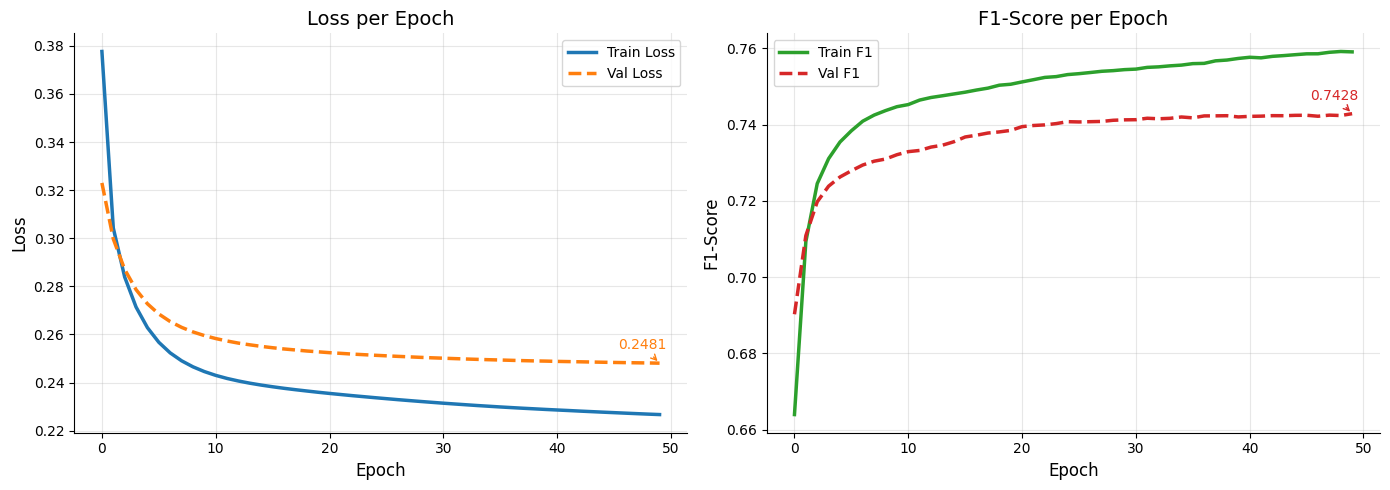

In [91]:
trainer.visualize()

# W2V модель

In [99]:
class w2vMLP(nn.Module):
  def __init__(self):
    super(w2vMLP, self).__init__()
    self.mlp = nn.Sequential(
        nn.Linear(50, 256, bias=False),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(256, 128, bias=False),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),

            nn.Linear(128, 64, bias=False),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),

            nn.Linear(64, 20)
        )

  def forward(self, x):
    return self.mlp(x)

In [100]:
class W2Vdataset(Dataset):
    def __init__(self, x, y, w2v):
        super(W2Vdataset, self).__init__()
        self.unk_vec = np.mean(w2v.wv.vectors, axis=0)
        self.embx = []
        self.y = y
        for sent in x:
            emb_els = []
            for tok in sent: # обработка <UNK>
                if tok in w2v.wv:
                    emb_els.append(w2v.wv[tok])
                else:
                    emb_els.append(self.unk_vec)
            if len(emb_els) == 0:
                emb_els = [self.unk_vec]
            self.embx.append(torch.mean(torch.tensor(emb_els), dim=0))

    def __getitem__(self, idx):
        embeddings, labels = self.embx[idx], self.y[idx]
        embeddings, labels = embeddings.float().to(DEVICE), labels.float().to(DEVICE)
        return embeddings, labels

    def __len__(self):
        return len(self.y)

In [101]:
w2vmodel = w2vMLP().to(DEVICE)
w2v = Word2Vec(train_normal, window=5, workers=4, vector_size=50, min_count=1, epochs=8)

In [102]:
TrainData, TestData = W2Vdataset(train_normal, train_labels, w2v), W2Vdataset(val_normal, val_labels, w2v)

In [103]:
TrainData[0][0].shape

torch.Size([50])

In [104]:
train_dataloader = DataLoader(TrainData, batch_size=16)
val_dataloader = DataLoader(TestData, batch_size=16)

In [105]:
trainer = Trainer(w2vmodel, n_epoch=24, print_every=3, pos_weight=pos_weight)
trainer.train(train_dataloader, val_dataloader)

EPOCH 0
---------------
Loss: 0.73212
Loss: 0.31841
Loss: 0.34476
Train Loss: 0.36687	 Train Macro F1: 0.64483
Val Loss: 0.30737	 Val Macro F1: 0.6918

EPOCH 3
---------------
Loss: 0.26873
Loss: 0.30871
Loss: 0.3277
Train Loss: 0.31556	 Train Macro F1: 0.68538
Val Loss: 0.29131	 Val Macro F1: 0.70236

EPOCH 6
---------------
Loss: 0.26277
Loss: 0.29292
Loss: 0.33164
Train Loss: 0.30706	 Train Macro F1: 0.69188
Val Loss: 0.28568	 Val Macro F1: 0.70495

EPOCH 9
---------------
Loss: 0.24825
Loss: 0.28332
Loss: 0.32027
Train Loss: 0.3015	 Train Macro F1: 0.6986
Val Loss: 0.28176	 Val Macro F1: 0.70952

EPOCH 12
---------------
Loss: 0.26152
Loss: 0.28326
Loss: 0.34269
Train Loss: 0.29801	 Train Macro F1: 0.69961
Val Loss: 0.28062	 Val Macro F1: 0.70855

EPOCH 15
---------------
Loss: 0.25103
Loss: 0.27942
Loss: 0.30083
Train Loss: 0.2961	 Train Macro F1: 0.70296
Val Loss: 0.27934	 Val Macro F1: 0.71084

EPOCH 18
---------------
Loss: 0.25725
Loss: 0.29622
Loss: 0.30735
Train Loss: 0.2938

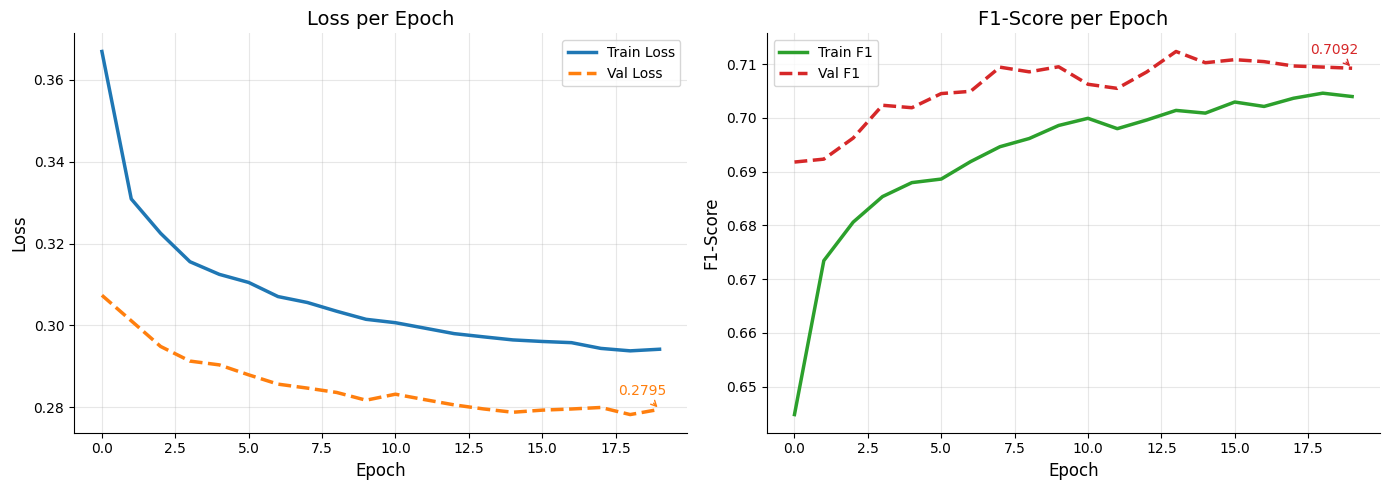

In [106]:
trainer.visualize()

# Встроенный эмбеддинг в нейросетевое решение на свёрточных сетях

Embedding → [Conv1D(k=3,4,5) → ReLU → GlobalMaxPool]* → Concatenate → Dropout → Dense → Softmax

In [107]:
class Navec_Dataset():
    def __init__(self, text, labels, navec, seq_len=mean_count_tokens):
        self.text = text
        self.labels = labels
        self.navec = navec
        self.emb = NavecEmbedding(navec)
        self.seq_len = int(seq_len)
    def __getitem__(self, idx):
        text, labels = self.text[idx], self.labels[idx]
        emb = NavecEmbedding(navec)

        ids = [
            navec.vocab[token] if token in navec.vocab else navec.vocab['<unk>']
            for token in text
            ]

        text_ids = torch.tensor(ids, dtype=torch.long)

        if len(text_ids) < self.seq_len:
            text_ids = torch.nn.functional.pad(text_ids, (0, self.seq_len - len(text_ids)), value=navec.vocab['<pad>'])
        else:
            text_ids = text_ids[:self.seq_len]

        text_vec = self.emb(text_ids)

        text_vec, labels = text_vec.float().to(DEVICE), labels.float().to(DEVICE)

        return text_vec, labels

    def __len__(self):
        return len(self.text)

In [108]:
class CNN_text(nn.Module):
    def __init__(self, embed_dim=300, num_classes=20, dropout=0.5):
        super(CNN_text, self).__init__()
        self.kernel_sizes = [3, 4, 5]
        self.conv_layers = nn.ModuleList([
            nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=100, kernel_size=k),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=k),
            )
            for k in self.kernel_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(self.kernel_sizes) * 100, num_classes)

    def forward(self, x):
        x = x.transpose(1, 2)

        conv_outputs = []
        for conv in self.conv_layers:
            c = conv(x)
            c = torch.nn.functional.relu(c)
            c = torch.nn.functional.max_pool1d(c, kernel_size=c.shape[2])
            c = c.squeeze(2)
            conv_outputs.append(c)

        x = torch.cat(conv_outputs, dim=1)

        x = self.dropout(x)
        x = self.fc(x)
        return x


In [110]:
path = 'navec_hudlit_v1_12B_500K_300d_100q (1).tar'
navec = Navec.load(path)

In [111]:
TrainDataset, TestDataset = Navec_Dataset(train_normal, train_labels, navec, mean_count_tokens), Navec_Dataset(val_normal, val_labels, navec, mean_count_tokens)

C:\Users\username\Python3.12\Lib\site-packages\slovnet\model\emb.py:46: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  torch.from_numpy(navec.pq.indexes),


In [112]:
train_dataloader = DataLoader(TrainDataset, batch_size=16)
val_dataloader = DataLoader(TestDataset, batch_size=16)

In [113]:
cnnmodel = CNN_text().to(DEVICE)
cnnmodel.eval()
cnnmodel(torch.rand(size=(16, 75, 300)).to(DEVICE)).shape

torch.Size([16, 20])

In [114]:
trainer = Trainer(cnnmodel, n_epoch=24, print_every=4, pos_weight=pos_weight)
trainer.train(train_dataloader, val_dataloader)

EPOCH 0
---------------
Loss: 0.75144
Loss: 0.26199
Loss: 0.26281
Train Loss: 0.32598	 Train Macro F1: 0.67232
Val Loss: 0.26667	 Val Macro F1: 0.70605

EPOCH 4
---------------
Loss: 0.20942
Loss: 0.22458
Loss: 0.2357
Train Loss: 0.2414	 Train Macro F1: 0.74633
Val Loss: 0.23806	 Val Macro F1: 0.73997

EPOCH 8
---------------
Loss: 0.22838
Loss: 0.19262
Loss: 0.22848
Train Loss: 0.22345	 Train Macro F1: 0.76945
Val Loss: 0.23238	 Val Macro F1: 0.75128

EPOCH 12
---------------
Loss: 0.18035
Loss: 0.24203
Loss: 0.26182
Train Loss: 0.21414	 Train Macro F1: 0.77883
Val Loss: 0.23157	 Val Macro F1: 0.75653

EPOCH 16
---------------
Loss: 0.18054
Loss: 0.20334
Loss: 0.22248
Train Loss: 0.20818	 Train Macro F1: 0.78415
Val Loss: 0.22832	 Val Macro F1: 0.75947

EPOCH 20
---------------
Loss: 0.20934
Loss: 0.17601
Loss: 0.23182
Train Loss: 0.20435	 Train Macro F1: 0.78514
Val Loss: 0.22809	 Val Macro F1: 0.765

Loss stopped improving. Terminating training.


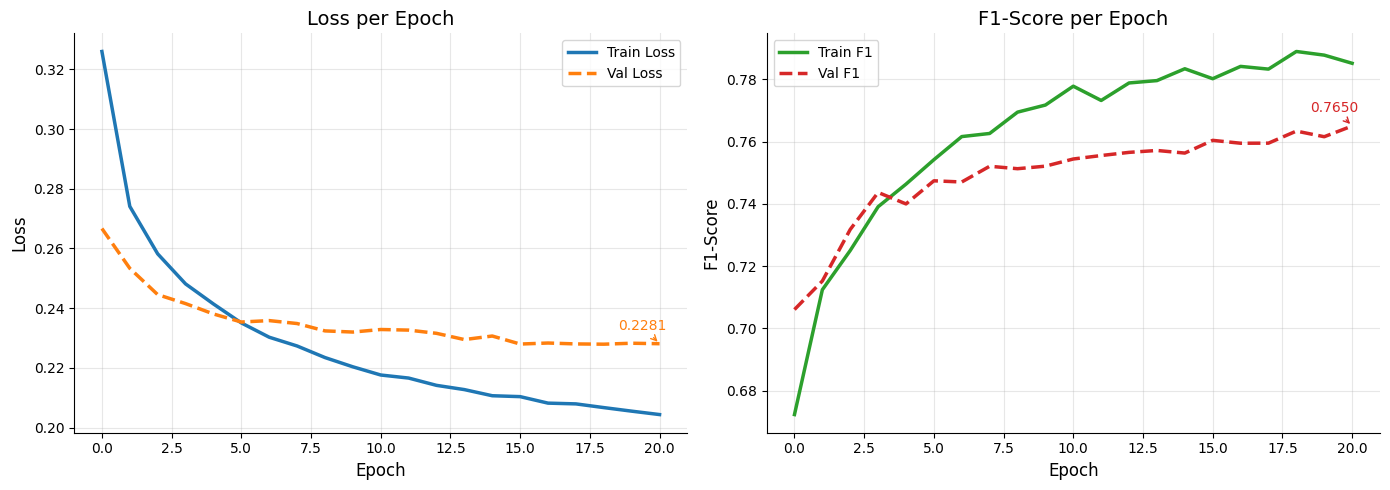

In [115]:
trainer.visualize()

In [116]:
torch.save(trainer.model.state_dict(), "cnn_model.pth")

# Свой эмбеддинг в нейросетевое решение на свёрточных сетях

In [117]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.normalizers import Lowercase
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import BertPreTokenizer

model = WordLevel(unk_token='<UNK>')

tokenizer_words = Tokenizer(model)
tokenizer_words.normalizer = Lowercase()
tokenizer_words.pre_tokenizer = BertPreTokenizer()
tokenizer_words.enable_padding(direction='right', pad_id=0, pad_token='<PAD>', max_length=300)
tokenizer_words.enable_truncation(max_length=300)

trainer_words = WordLevelTrainer(special_tokens=['<PAD>', '<UNK>'],
                                 unk_token='<UNK>', pad_token='<PAD>')

tokenizer_words.train_from_iterator(train_tokens_sent, trainer=trainer_words)

In [118]:
class CNNDataset():
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels

        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text, labels = self.text[idx], self.labels[idx].float().to(DEVICE)

        tokenized = torch.tensor(self.tokenizer.encode(text).ids, dtype=torch.long).to(DEVICE)
        
        return tokenized, labels

    def __len__(self):
        return len(self.text)

In [119]:
class CNN_text_emb(nn.Module):
    def __init__(self, vocab_size, embed_dim=500, num_classes=20, dropout=0.5):
        super(CNN_text_emb, self).__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.kernel_sizes = [3, 4, 5]
        self.conv_layers = nn.ModuleList([
            
            nn.Conv1d(in_channels=embed_dim, out_channels=100, kernel_size=k)
            for k in self.kernel_sizes
        
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(self.kernel_sizes) * 100, num_classes)

        self.init_weights()  

    def init_weights(self):
        nn.init.xavier_uniform_(self.emb.weight)
        
        for conv in self.conv_layers: 
            nn.init.xavier_uniform_(conv.weight)
            if conv.bias is not None:
                nn.init.zeros_(conv.bias)
    
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, x):
        x = self.emb(x)
        x = x.transpose(1, 2)
        
        conv_outputs = []
        for conv in self.conv_layers:
            c = conv(x)
            c = torch.nn.functional.relu(c)
            c = torch.nn.functional.max_pool1d(c, kernel_size=c.shape[2])
            c = c.squeeze(2)
            conv_outputs.append(c)

        x = torch.cat(conv_outputs, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


In [120]:
TrainData, TestData = CNNDataset(train_tokens_sent, train_labels, tokenizer_words), CNNDataset(val_tokens_sent, val_labels, tokenizer_words)

In [121]:
train_dataloader = DataLoader(TrainData, batch_size=32)
val_dataloader = DataLoader(TestData, batch_size=16)

In [122]:
cnnmodel = CNN_text_emb(tokenizer_words.get_vocab_size(), ).to(DEVICE)

In [123]:
trainer = Trainer(cnnmodel, n_epoch=24, print_every=4, pos_weight=pos_weight)
trainer.train(train_dataloader, val_dataloader)

EPOCH 0
---------------
Loss: 0.69298
Loss: 0.31689
Train Loss: 0.36254	 Train Macro F1: 0.63402
Val Loss: 0.2947	 Val Macro F1: 0.68727

EPOCH 4
---------------
Loss: 0.27162
Loss: 0.23803
Train Loss: 0.25899	 Train Macro F1: 0.71642
Val Loss: 0.25103	 Val Macro F1: 0.71539

EPOCH 8
---------------
Loss: 0.26903
Loss: 0.22175
Train Loss: 0.23875	 Train Macro F1: 0.72801
Val Loss: 0.24018	 Val Macro F1: 0.72358

EPOCH 12
---------------
Loss: 0.26148
Loss: 0.20876
Train Loss: 0.22085	 Train Macro F1: 0.74164
Val Loss: 0.23693	 Val Macro F1: 0.72598

EPOCH 16
---------------
Loss: 0.22722
Loss: 0.19344
Train Loss: 0.2065	 Train Macro F1: 0.75436
Val Loss: 0.23467	 Val Macro F1: 0.72609

EPOCH 20
---------------
Loss: 0.22851
Loss: 0.16265
Train Loss: 0.19257	 Train Macro F1: 0.76137
Val Loss: 0.23367	 Val Macro F1: 0.73956

Loss stopped improving. Terminating training.


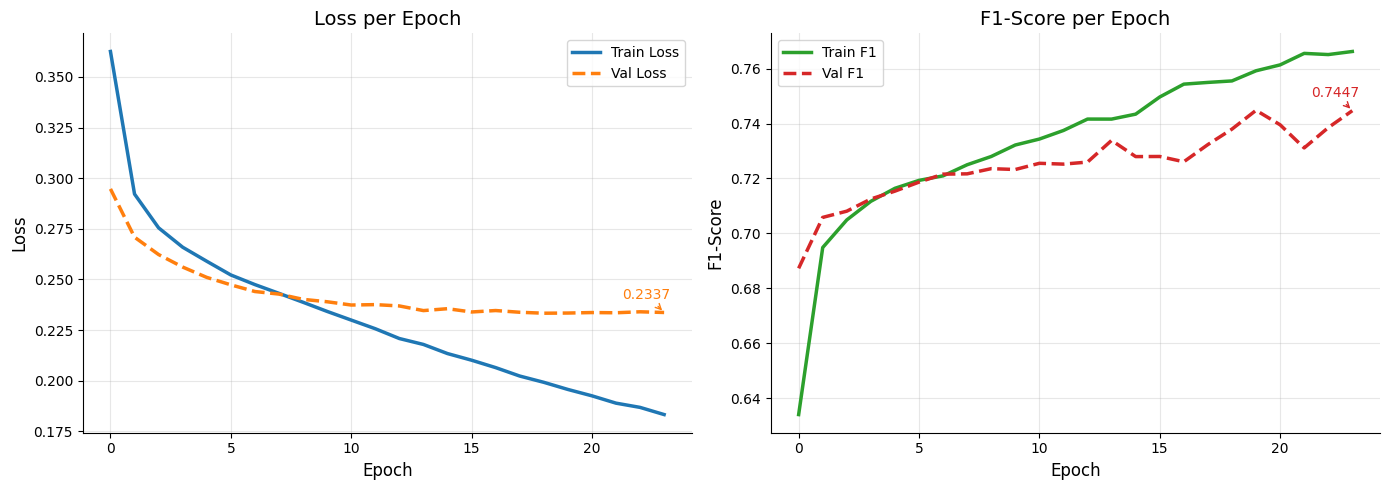

In [124]:
trainer.visualize()

In [125]:
torch.save(trainer.model.state_dict(), "cnn_model2.pth")

# Встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях;

In [126]:
class Navec_Dataset():
    def __init__(self, text, labels, navec, seq_len=mean_count_tokens):
        self.text = text
        self.labels = labels
        self.navec = navec
        self.emb = NavecEmbedding(navec)
        self.seq_len = int(seq_len)
    def __getitem__(self, idx):
        text, labels = self.text[idx], self.labels[idx]
        emb = NavecEmbedding(navec)

        ids = [
            navec.vocab[token] if token in navec.vocab else navec.vocab['<unk>']
            for token in text
            ]

        text_ids = torch.tensor(ids, dtype=torch.long)

        if len(text_ids) < self.seq_len:
            text_ids = torch.nn.functional.pad(text_ids, (0, self.seq_len - len(text_ids)), value=navec.vocab['<pad>'])
        else:
            text_ids = text_ids[:self.seq_len]

        text_vec = self.emb(text_ids)

        text_vec, labels = text_vec.float().to(DEVICE), labels.float().to(DEVICE)

        return text_vec, labels

    def __len__(self):
        return len(self.text)

In [127]:
class RNN(nn.Module):
    def __init__(self, embed_dim=300, hidden_size=128, num_classes=20):
        super(RNN, self).__init__()
        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size, dropout=0.5,
                          num_layers=2, bidirectional=False, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, h = self.gru(x)
        h = h[-1]
        logits = self.fc(h)

        return logits

In [129]:
path = 'navec_hudlit_v1_12B_500K_300d_100q (1).tar'
navec = Navec.load(path)

In [130]:
TrainDataset = Navec_Dataset(train_normal, train_labels, navec, mean_count_tokens) 
TestDataset = Navec_Dataset(val_normal, val_labels, navec, mean_count_tokens)

In [131]:
train_dataloader = DataLoader(TrainDataset, batch_size=16)
val_dataloader = DataLoader(TestDataset, batch_size=16)

In [132]:
rnnmodel = RNN().to(DEVICE)

In [133]:
trainer = Trainer(rnnmodel, n_epoch=24, print_every=4, weight_decay=2e-4, pos_weight=pos_weight)
trainer.train(train_dataloader, val_dataloader)

EPOCH 0
---------------
Loss: 0.70477
Loss: 0.27742
Loss: 0.28792
Train Loss: 0.31573	 Train Macro F1: 0.66492
Val Loss: 0.28852	 Val Macro F1: 0.66615

EPOCH 4
---------------
Loss: 0.22087
Loss: 0.2417
Loss: 0.27074
Train Loss: 0.25822	 Train Macro F1: 0.72334
Val Loss: 0.25655	 Val Macro F1: 0.71747

EPOCH 8
---------------
Loss: 0.20645
Loss: 0.22703
Loss: 0.26432
Train Loss: 0.24322	 Train Macro F1: 0.73254
Val Loss: 0.24517	 Val Macro F1: 0.7288

EPOCH 12
---------------
Loss: 0.19906
Loss: 0.21105
Loss: 0.25812
Train Loss: 0.23408	 Train Macro F1: 0.73776
Val Loss: 0.23955	 Val Macro F1: 0.73155

EPOCH 16
---------------
Loss: 0.19271
Loss: 0.19712
Loss: 0.24487
Train Loss: 0.228	 Train Macro F1: 0.7408
Val Loss: 0.2365	 Val Macro F1: 0.73204

EPOCH 20
---------------
Loss: 0.19316
Loss: 0.19384
Loss: 0.2424
Train Loss: 0.22365	 Train Macro F1: 0.74251
Val Loss: 0.23533	 Val Macro F1: 0.7367

EPOCH 24
---------------
Loss: 0.19795
Loss: 0.19428
Loss: 0.24569
Train Loss: 0.21957	

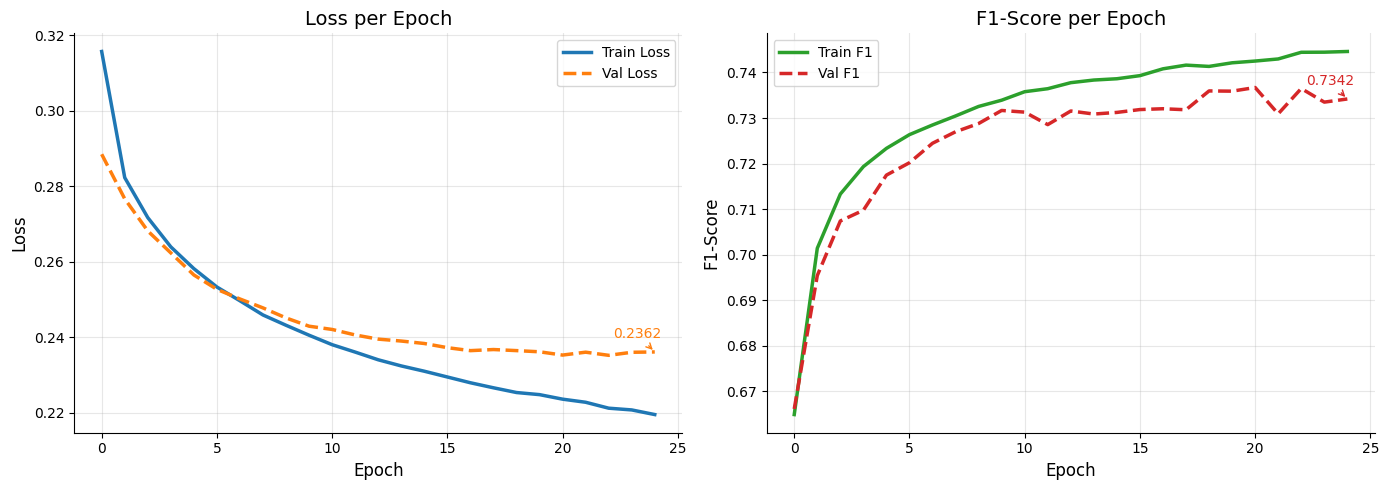

In [134]:
trainer.visualize()

# Собственный эмбеддинг в нейросетевое решение на рекуррентных сетях

In [135]:
model = WordLevel(unk_token='<UNK>')

tokenizer = Tokenizer(model)
tokenizer.normalizer = Lowercase()
tokenizer.pre_tokenizer = CharDelimiterSplit(" ")

tokenizer.enable_padding(direction='right', pad_id=0, pad_token='<PAD>', max_length=220)
tokenizer.enable_truncation(max_length=220)

trainer = WordLevelTrainer(special_tokens=['<PAD>', '<UNK>'],
                           unk_token='<UNK>', pad_token='<PAD>')

tokenizer.train_from_iterator(train_normal_sent, trainer=trainer)

In [136]:
class RNNDataset():
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels

        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text, labels = self.text[idx], self.labels[idx].float().to(DEVICE)

        tokenized = torch.tensor(self.tokenizer.encode(text).ids, dtype=torch.long).to(DEVICE)
        
        return tokenized, labels

    def __len__(self):
        return len(self.text)

In [137]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, hidden_size=128, num_classes=20):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size,
                          num_layers=3, bidirectional=True, dropout=0.5, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        emb = self.embedding(x)
        out, h = self.gru(emb)
        h = h[-1]
        logits = self.fc(h)

        return logits

In [138]:
train_dataset = RNNDataset(train_tokens_sent, train_labels, tokenizer)
val_dataset = RNNDataset(val_tokens_sent, val_labels, tokenizer)

In [139]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [140]:
rnnmodel = RNN(tokenizer.get_vocab_size()).to(DEVICE)

In [141]:
trainer = Trainer(rnnmodel, n_epoch=24, print_every=4, weight_decay=1e-4, pos_weight=pos_weight, patience=40)
trainer.train(train_dataloader, val_dataloader)

EPOCH 0
---------------
Loss: 0.69702
Loss: 0.28683
Train Loss: 0.33075	 Train Macro F1: 0.65934
Val Loss: 0.31082	 Val Macro F1: 0.67489

EPOCH 4
---------------
Loss: 0.25022
Loss: 0.24122
Train Loss: 0.24755	 Train Macro F1: 0.73594
Val Loss: 0.25054	 Val Macro F1: 0.71754

EPOCH 8
---------------
Loss: 0.24322
Loss: 0.21879
Train Loss: 0.22737	 Train Macro F1: 0.76338
Val Loss: 0.24106	 Val Macro F1: 0.72656

EPOCH 12
---------------
Loss: 0.21231
Loss: 0.20516
Train Loss: 0.20381	 Train Macro F1: 0.77513
Val Loss: 0.24615	 Val Macro F1: 0.73083

EPOCH 16
---------------
Loss: 0.18959
Loss: 0.16645
Train Loss: 0.18388	 Train Macro F1: 0.78924
Val Loss: 0.26166	 Val Macro F1: 0.74065

EPOCH 20
---------------
Loss: 0.1732
Loss: 0.15194
Train Loss: 0.1674	 Train Macro F1: 0.80157
Val Loss: 0.27559	 Val Macro F1: 0.73948

EPOCH 24
---------------
Loss: 0.16858
Loss: 0.14505
Train Loss: 0.15588	 Train Macro F1: 0.81067
Val Loss: 0.28222	 Val Macro F1: 0.7558



In [142]:
torch.save(trainer.model.state_dict(), "rnn_embed.pth")

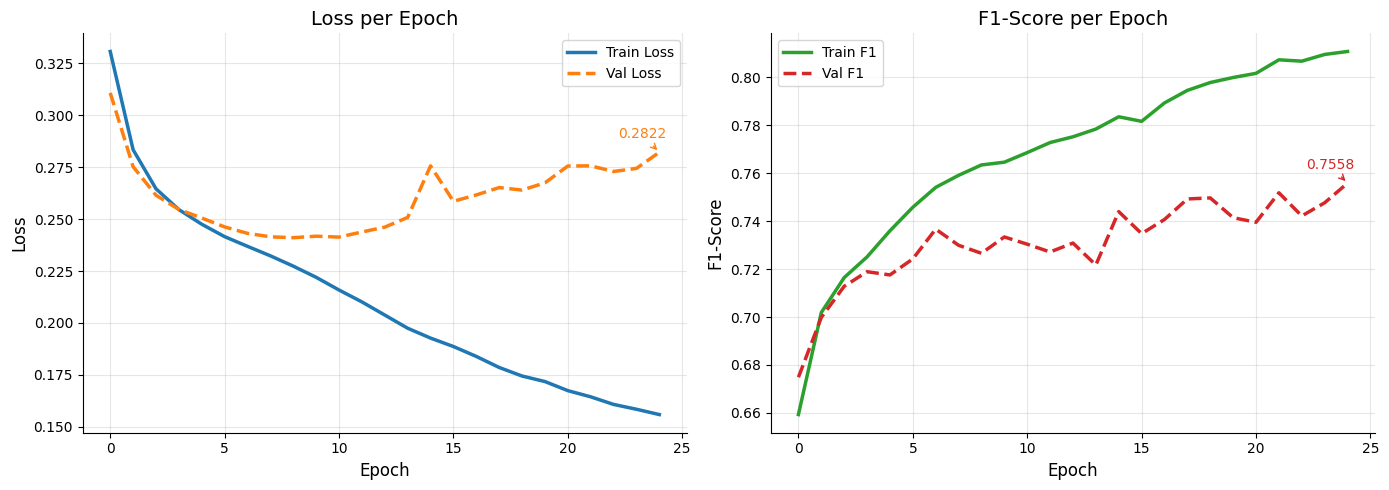

In [143]:
trainer.visualize()

# Генерация с помощью декодера

In [183]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data.shape, test_data.shape

((29568, 3), (7392, 2))

In [184]:
train_labels = train_data['labels'].apply(lambda a: list(map(int, a.split())))
train_labels = torch.Tensor(train_labels)

In [172]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [ ]:
model_name = 'sberbank-ai/rugpt3small_based_on_gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name).cuda()
prompt = ''

def generate_text():
    prompt = "Типичное рекламное объявление в России напиши:"
    input_ids = tokenizer.encode(prompt, return_tensors='pt').cuda()

    output_ids = model.generate(
        input_ids=input_ids,
        max_length=150,
        temperature=0.8,
        top_k=40,
        top_p=0.95,
        do_sample=True,
        num_return_sequences=1,
        pad_token_id=tokenizer.eos_token_id
    )

    generated_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

    if "Типичное рекламное объявление в России напиши:" in generated_text:
        generated_text = generated_text.split("Типичное рекламное объявление в России напиши:")[1].strip()

    return generated_text

new_texts = []

for i in tqdm(range(1000)):
    new_text = generate_text()

    new_texts.append(new_text)

In [185]:
prob = torch.Tensor(train_labels).mean(axis=0)
new_labels = np.random.binomial(1, prob, size=(1000, 20))
generated_data = pd.DataFrame({'text': new_texts, 'labels': new_labels.tolist()})

In [182]:
generated_data.to_csv('generated_data.csv', index=False) 

In [187]:
train_sapmling_data = pd.concat([train_data[['text', 'labels']] , generated_data], ); train_sapmling_data

,text,labels
0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...
995,"""Продам новую модель пылесоса MARKET BEAT COMP...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, ..."
996,"""Сдачу в аренду с водителем и водителем в офис...","[1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, ..."
997,"""Здравствуйте, мы предлагаем вам услугу, предл...","[1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, ..."
998,http://snob.ru/...✂ \n И не забудь о своем авт...,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."


In [188]:
strain_text, sval_text, strain_labels, sval_labels = train_test_split(train_sapmling_data.text, train_sapmling_data.labels, test_size=0.3, random_state=42)

In [189]:
train_processed, train_tokens, train_normal = text_preprocessing(strain_text, tokenize=True, normalize=True)
val_processed, val_tokens, val_normal = text_preprocessing(sval_text, tokenize=True, normalize=True)

  0%|          | 0/21397 [00:00<?, ?it/s]

  0%|          | 0/21397 [00:00<?, ?it/s]

  0%|          | 0/9171 [00:00<?, ?it/s]

  0%|          | 0/9171 [00:00<?, ?it/s]

In [190]:
test_processed, test_tokens, test_normal = text_preprocessing(test_data.text, tokenize=True, normalize=True)

  0%|          | 0/7392 [00:00<?, ?it/s]

  0%|          | 0/7392 [00:00<?, ?it/s]

In [195]:
model = WordLevel(unk_token='<UNK>')

tokenizer = Tokenizer(model)
tokenizer.normalizer = Lowercase()
tokenizer.pre_tokenizer = CharDelimiterSplit(" ")

tokenizer.enable_padding(direction='right', pad_id=0, pad_token='<PAD>', max_length=220)
tokenizer.enable_truncation(max_length=220)

trainer = WordLevelTrainer(special_tokens=['<PAD>', '<UNK>'],
                           unk_token='<UNK>', pad_token='<PAD>')

tokenizer.train_from_iterator(train_normal_sent, trainer=trainer)

In [196]:
strain_normal_sent = list(map(lambda t: " ".join(t), train_normal))
sval_normal_sent = list(map(lambda t: " ".join(t), val_normal))
stest_normal_sent = list(map(lambda t: " ".join(t), test_normal))

strain_tokens_sent = list(map(lambda t: " ".join(t), train_tokens))
sval_tokens_sent = list(map(lambda t: " ".join(t), val_tokens))

In [197]:
train_dataset = RNNDataset(train_tokens_sent, train_labels, tokenizer)
val_dataset = RNNDataset(val_tokens_sent, val_labels, tokenizer)

In [198]:
train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [199]:
rnnmodel = RNN(tokenizer.get_vocab_size()).to(DEVICE)
trainer = Trainer(rnnmodel, n_epoch=24, print_every=4, weight_decay=1e-4, pos_weight=pos_weight, patience=40)
trainer.train(train_dataloader, val_dataloader)

EPOCH 0
---------------
Loss: 0.69528
Loss: 0.55276
Loss: 0.48801
Train Loss: 0.49699	 Train Macro F1: 0.47782
Val Loss: 0.49221	 Val Macro F1: 0.46958

EPOCH 4
---------------
Loss: 0.58822
Loss: 0.5506
Loss: 0.48361
Train Loss: 0.49487	 Train Macro F1: 0.47434
Val Loss: 0.49209	 Val Macro F1: 0.46958

EPOCH 8
---------------
Loss: 0.58427
Loss: 0.55001
Loss: 0.48213
Train Loss: 0.49423	 Train Macro F1: 0.47576
Val Loss: 0.49174	 Val Macro F1: 0.46958

EPOCH 12
---------------
Loss: 0.58298
Loss: 0.54997
Loss: 0.48168
Train Loss: 0.49405	 Train Macro F1: 0.47408
Val Loss: 0.49156	 Val Macro F1: 0.46958

EPOCH 16
---------------
Loss: 0.58284
Loss: 0.54986
Loss: 0.48149
Train Loss: 0.49392	 Train Macro F1: 0.47333
Val Loss: 0.49145	 Val Macro F1: 0.46958

EPOCH 20
---------------
Loss: 0.58284
Loss: 0.54968
Loss: 0.48141
Train Loss: 0.49383	 Train Macro F1: 0.47308
Val Loss: 0.4914	 Val Macro F1: 0.46958

EPOCH 24
---------------
Loss: 0.58293
Loss: 0.54972
Loss: 0.48128
Train Loss: 0.

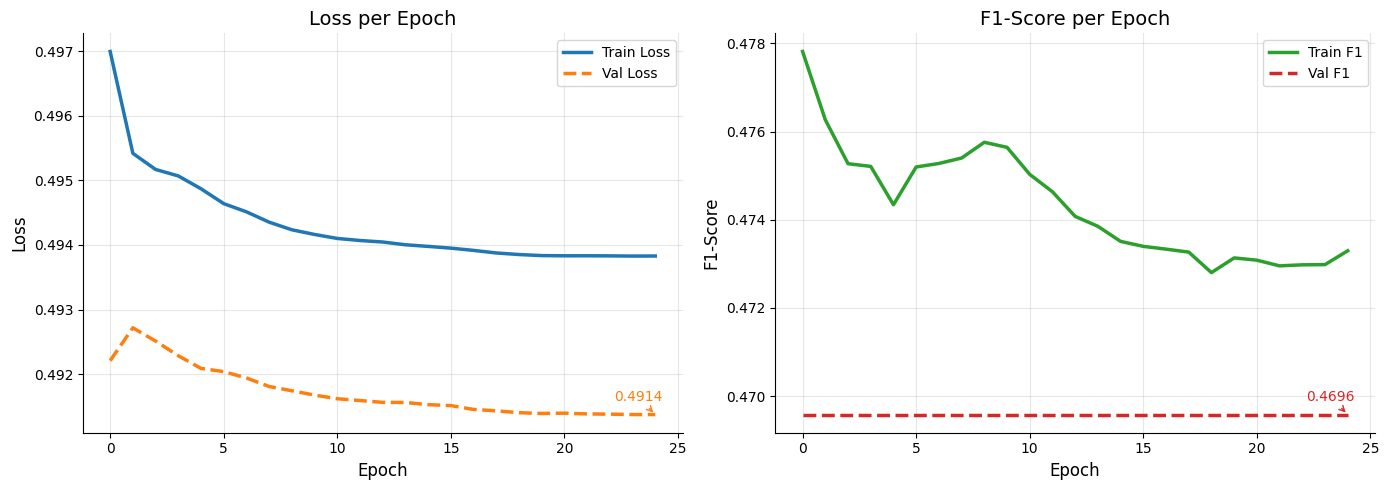

In [200]:
trainer.visualize()

Генерация новых рекламных слоганов не помогла модели достичь лучших результатов. В первую очередь это обусловлено низким качеством сгенерированных текстов, что не улучшает, а ухудшает выборки и как следствие метрики модели.

# Эмбеддер + BERT-like модель

In [145]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [146]:
class BERT_Dataset(Dataset):
    def __init__(self, text, labels, tokenizer):
        super(BERT_Dataset, self).__init__()
        self.text = text
        self.labels = labels
        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text, labels = self.text.iloc[idx], self.labels[idx]
        tokenized = tokenizer(text, 
                              padding='max_length',
                              truncation=True,
                              max_length=512,
                              return_tensors="pt")
        tokenized = {key: value.squeeze(0).to(DEVICE) for key, value in tokenized.items()}
        labels = labels.to(DEVICE)
        
        return tokenized, labels

    def __len__(self):
        return len(self.text)

In [147]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_name="bert-base-multilingual-cased", freeze_bert=True, num_classes=20):
        super().__init__()
        self.bert = BertModel.from_pretrained(bert_name)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, x):
        outputs = self.bert(**x)
        cls_output = outputs.last_hidden_state[:, 0]  # [CLS] токен
        cls_output = self.dropout(cls_output)
        return self.classifier(cls_output)

In [148]:
train_dataset = BERT_Dataset(train_processed, train_labels, tokenizer)
val_dataset = BERT_Dataset(val_processed, val_labels, tokenizer)

In [149]:
train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [150]:
bertmodel = BERTClassifier().to(DEVICE)

In [151]:
trainer = Trainer(bertmodel, n_epoch=3, print_every=1, weight_decay=2e-4, pos_weight=pos_weight)
trainer.train(train_dataloader, val_dataloader)

EPOCH 0
---------------
Loss: 0.73056
Loss: 0.33382
Loss: 0.35068
Train Loss: 0.36724	 Train Macro F1: 0.64184
Val Loss: 0.31091	 Val Macro F1: 0.69119

EPOCH 1
---------------
Loss: 0.30505
Loss: 0.34684
Loss: 0.32609
Train Loss: 0.32451	 Train Macro F1: 0.68252
Val Loss: 0.29736	 Val Macro F1: 0.69729

EPOCH 2
---------------
Loss: 0.30791
Loss: 0.29014
Loss: 0.31288
Train Loss: 0.31751	 Train Macro F1: 0.68945
Val Loss: 0.29279	 Val Macro F1: 0.7019

EPOCH 3
---------------
Loss: 0.2766
Loss: 0.31091
Loss: 0.31986
Train Loss: 0.31647	 Train Macro F1: 0.69009
Val Loss: 0.29034	 Val Macro F1: 0.69822



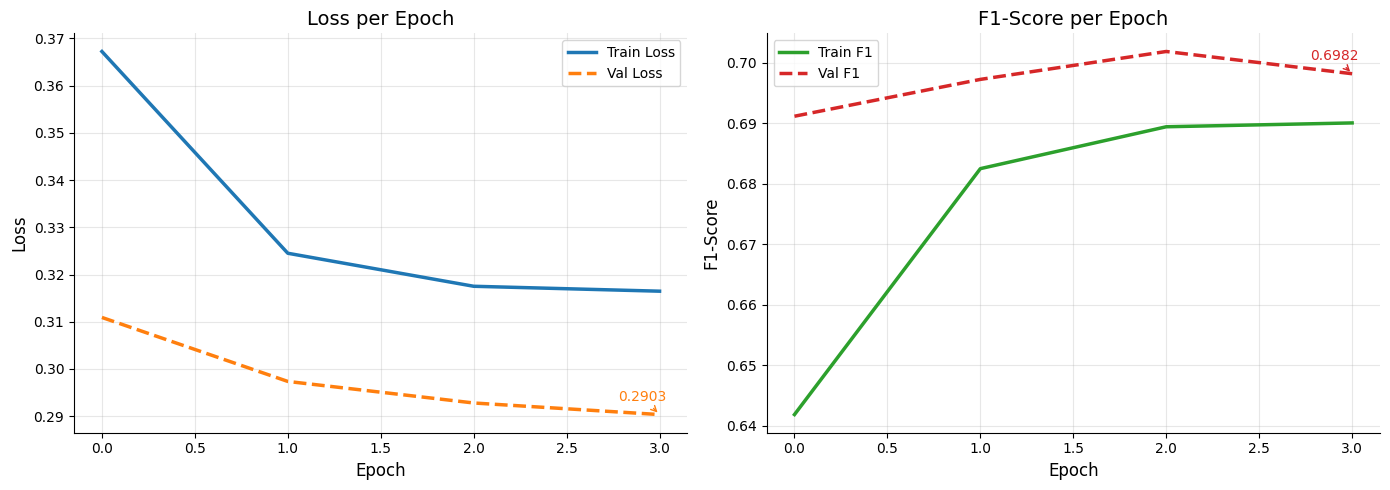

In [152]:
trainer.visualize()

# Competition

In [153]:
model = WordLevel(unk_token='<UNK>')

tokenizer = Tokenizer(model)
tokenizer.normalizer = Lowercase()
tokenizer.pre_tokenizer = CharDelimiterSplit(" ")

tokenizer.enable_padding(direction='right', pad_id=0, pad_token='<PAD>', max_length=370)
tokenizer.enable_truncation(max_length=370)

trainer = WordLevelTrainer(special_tokens=['<PAD>', '<UNK>'],
                           unk_token='<UNK>', pad_token='<PAD>')

tokenizer.train_from_iterator(train_tokens_sent, trainer=trainer)

In [154]:
class Trainer_comp():
    def __init__(self, model,
                 lr=1e-4, weight_decay=1e-4,
                 patience=5, n_epoch=10,
                 print_every=2, verbose_every=500, pos_weight=None, len_dl=10_000):
        self.model = model
        self.loss = nn.BCEWithLogitsLoss()

        trainable_params = list(filter(lambda p: p.requires_grad, self.model.parameters()))
        self.optimizer = optim.AdamW(trainable_params, lr=lr, weight_decay=weight_decay)
        
        

        self.n_epoch = n_epoch
        self.print_every = print_every
        self.verbose_every = verbose_every
        self.early_stopper = EarlyStopping(patience=patience)
        
        # self.scheduler = torch.optim.lr_scheduler.OneCycleLR(     
        #     self.optimizer, max_lr=1e-3,
        #     steps_per_epoch=len_dl,
        #     epochs=self.n_epoch+1,
        #     )
        self.scheduler = None
        
        self.losses = {'train': [], 'val': []}
        self.metrics = {'train': [], 'val': []}

    def train(self, train_dataloader, val_dataloader):
        verbose = False
        for epoch in range(self.n_epoch + 1):
            if self.print_every is not None and epoch % self.print_every == 0:
                print(f'EPOCH {epoch}\n---------------')
                verbose = self.verbose_every
            else:
                verbose = False

            train_res = self.train_loop(train_dataloader, verbose)
            val_res = self.eval_loop(val_dataloader, verbose)

            self.losses['train'].append(train_res[0])
            self.losses['val'].append(val_res[0])

            self.metrics['train'].append(train_res[1])
            self.metrics['val'].append(val_res[1])


            self.early_stopper(val_res[0])
            if self.early_stopper.early_stop:
                print(f'Loss stopped improving. Terminating training.')
                break

    def train_loop(self, dataloader, verbose=False):
        self.model.train()
        epoch_loss = 0

        ground_truth = []
        predictions = []

        for idx, (X, y) in enumerate(dataloader):
            predict_logits = self.model(X)
            batch_loss = self.loss(predict_logits, y.float())

            self.optimizer.zero_grad()
            batch_loss.backward()
            self.optimizer.step()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            if self.scheduler:
                self.scheduler.step()
                
            epoch_loss += batch_loss.item()

            ground_truth.extend(y.tolist())
            predict_class = (predict_logits > 0.5).int()
            predictions.extend(predict_class.tolist())

            if verbose and idx % verbose == 0:
                print(f'Loss: {round(batch_loss.item(), 5)}')

        epoch_loss /= len(dataloader)
        f1 = f1_score(ground_truth, predictions, average="macro")

        if verbose:
            print(f'Train Loss: {round(epoch_loss, 5)}\t Train Macro F1: {round(f1, 5)}')

        return epoch_loss, f1, ground_truth, predictions

    def eval_loop(self, dataloader, verbose=False):
        self.model.eval()
        epoch_loss = 0

        ground_truth = []
        predictions = []

        with torch.no_grad():
            for idx, (X, y) in enumerate(dataloader):
                predict_logits = self.model(X)
                batch_loss = self.loss(predict_logits, y.float())
                epoch_loss += batch_loss.item()

                ground_truth.extend(y.tolist())
                predict_class = (predict_logits > 0.5).int()
                predictions.extend(predict_class.tolist())

        epoch_loss /= len(dataloader)
        f1 = f1_score(ground_truth, predictions, average="macro")

        if verbose:
            print(f'Val Loss: {round(epoch_loss, 5)}\t Val Macro F1: {round(f1, 5)}\n')

        return epoch_loss, f1, ground_truth, predictions

    def visualize(self):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
        colors = plt.get_cmap('tab10').colors

        axes[0].plot(self.losses['train'], label='Train Loss', color=colors[0], linewidth=2.5)
        axes[0].plot(self.losses['val'], label='Val Loss', color=colors[1], linewidth=2.5, linestyle='--')

        axes[0].set_title('Loss per Epoch', fontsize=14)
        axes[0].set_xlabel('Epoch', fontsize=12)
        axes[0].set_ylabel('Loss', fontsize=12)
        axes[0].grid(alpha=0.3)
        axes[0].legend(fontsize=10)
        axes[0].spines['top'].set_visible(False)
        axes[0].spines['right'].set_visible(False)


        axes[0].annotate(f"{self.losses['val'][-1]:.4f}",
                        xy=(len(self.losses['val']) - 1, self.losses['val'][-1]),
                        xytext=(-30, 10), textcoords='offset points',
                        fontsize=10, color=colors[1],
                        arrowprops=dict(arrowstyle='->', color=colors[1]))


        axes[1].plot(self.metrics['train'], label='Train F1', color=colors[2], linewidth=2.5)
        axes[1].plot(self.metrics['val'], label='Val F1', color=colors[3], linewidth=2.5, linestyle='--')

        axes[1].set_title('F1-Score per Epoch', fontsize=14)
        axes[1].set_xlabel('Epoch', fontsize=12)
        axes[1].set_ylabel('F1-Score', fontsize=12)
        axes[1].grid(alpha=0.3)
        axes[1].legend(fontsize=10)
        axes[1].spines['top'].set_visible(False)
        axes[1].spines['right'].set_visible(False)

        axes[1].annotate(f"{self.metrics['val'][-1]:.4f}",
                        xy=(len(self.metrics['val']) - 1, self.metrics['val'][-1]),
                        xytext=(-30, 10), textcoords='offset points',
                        fontsize=10, color=colors[3],
                        arrowprops=dict(arrowstyle='->', color=colors[3]))

        plt.tight_layout()
        plt.show()

In [155]:
class RNNDataset():
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels

        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text, labels = self.text[idx], self.labels[idx].float().to(DEVICE)

        tokenized = torch.tensor(self.tokenizer.encode(text).ids, dtype=torch.long).to(DEVICE)
        
        return tokenized, labels

    def __len__(self):
        return len(self.text)

In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedRNN(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 embed_dim: int = 600,
                 hidden_size: int = 128,
                 num_classes: int = 20,
                 pad_idx: int = 0):
        
        super(ImprovedRNN, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.embed_dropout = nn.Dropout(0.5)
        self.lstm= nn.LSTM(input_size=embed_dim,
                          hidden_size=hidden_size,
                          num_layers=3,
                          bidirectional=True,
                          dropout=0.2,
                          batch_first=True)
        
        
        self.transformer = nn.TransformerEncoderLayer(
            d_model=hidden_size * 2,
            nhead=8,
            dim_feedforward=hidden_size,
            dropout=0.2,
            batch_first=True
        )
        
        self.fc1 = nn.Linear(hidden_size * 4, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.gelu = nn.GELU()
        self.fc_dropout = nn.Dropout(0.4)
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_size, 32, bias=False),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.Linear(32, num_classes)
                )
       
        
        nn.init.xavier_uniform_(self.fc1.weight)

    def forward(self, x):
        emb = self.embedding(x)        
        emb = self.embed_dropout(emb)

        out, (hn, c) = self.lstm(emb)
        
        out = self.transformer(out)
        
        
        avg_pool = out.mean(dim=1)
        max_pool, _ = out.max(dim=1)
        
        rep = torch.cat([avg_pool, max_pool], dim=1)
        
        x = self.fc1(rep)             
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.fc_dropout(x)

        logits = self.fc2(x)            
        return logits

In [157]:
train_dataset = RNNDataset(train_tokens_sent, train_labels, tokenizer)
val_dataset = RNNDataset(val_tokens_sent, val_labels, tokenizer)

In [158]:
train_dataloader = DataLoader(train_dataset, batch_size=16)
val_dataloader = DataLoader(val_dataset, batch_size=16)

In [159]:
rnnmodel = ImprovedRNN(tokenizer.get_vocab_size()).to(DEVICE)

In [160]:
trainer = Trainer_comp(rnnmodel, n_epoch=45, print_every=5, weight_decay=1e-2, lr=1e-3, pos_weight=pos_weight, patience=45, len_dl=len(train_dataloader))
trainer.train(train_dataloader, val_dataloader)

EPOCH 0
---------------
Loss: 0.71144
Loss: 0.33097
Loss: 0.27357
Train Loss: 0.34127	 Train Macro F1: 0.65492
Val Loss: 0.30751	 Val Macro F1: 0.65869

EPOCH 5
---------------
Loss: 0.22115
Loss: 0.24722
Loss: 0.21322
Train Loss: 0.23173	 Train Macro F1: 0.73967
Val Loss: 0.25568	 Val Macro F1: 0.7256

EPOCH 10
---------------
Loss: 0.18104
Loss: 0.19252
Loss: 0.1998
Train Loss: 0.20228	 Train Macro F1: 0.76359
Val Loss: 0.23957	 Val Macro F1: 0.76214

EPOCH 15
---------------
Loss: 0.14232
Loss: 0.17157
Loss: 0.18606
Train Loss: 0.17922	 Train Macro F1: 0.7928
Val Loss: 0.23365	 Val Macro F1: 0.77804

EPOCH 20
---------------
Loss: 0.16721
Loss: 0.14518
Loss: 0.14597
Train Loss: 0.16135	 Train Macro F1: 0.80515
Val Loss: 0.24574	 Val Macro F1: 0.78447

EPOCH 25
---------------
Loss: 0.1356
Loss: 0.14604
Loss: 0.13056
Train Loss: 0.14628	 Train Macro F1: 0.82432
Val Loss: 0.25906	 Val Macro F1: 0.79595

EPOCH 30
---------------
Loss: 0.13519
Loss: 0.12749
Loss: 0.10365
Train Loss: 0.1

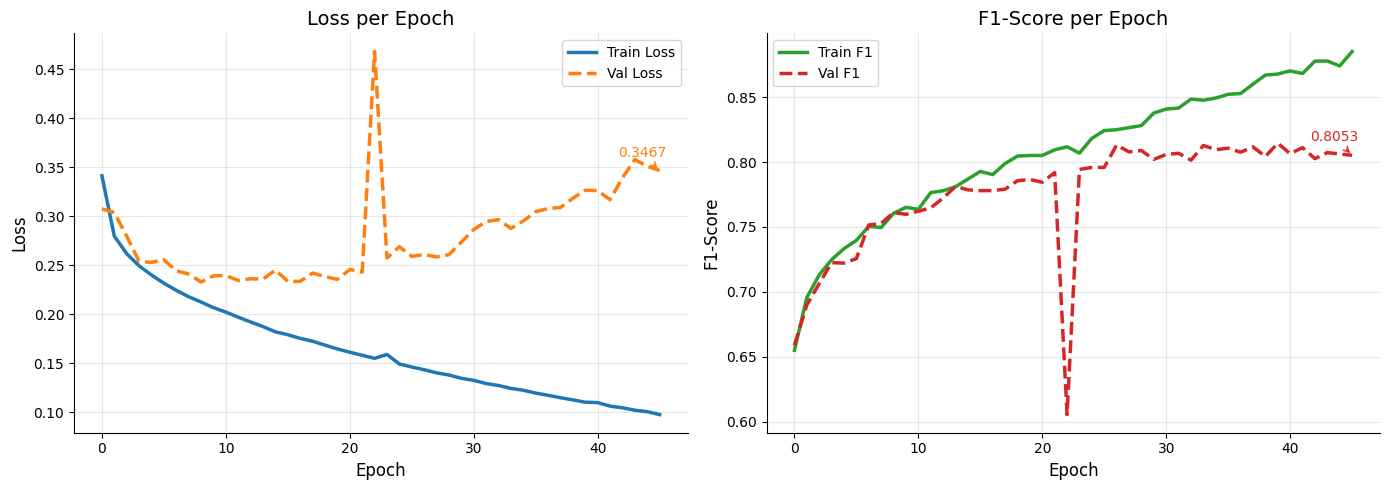

In [161]:
trainer.visualize()

In [268]:
class RNNDataset():
    def __init__(self, text, labels, tokenizer):
        self.text = text
        self.labels = labels

        self.tokenizer = tokenizer

    def __getitem__(self, idx):
        text = self.text[idx]
        tokenized = torch.tensor(self.tokenizer.encode(text).ids, dtype=torch.long).to(DEVICE)
        
        if self.labels:
            labels = self.labels[idx].float().to(DEVICE)
            return tokenized, labels
        else:
            return tokenized

    def __len__(self):
        return len(self.text)


In [269]:
test_processed, _, _ = text_preprocessing(test_data.text, tokenize=False, normalize=False)

test_dataset = RNNDataset(test_processed, None, tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

y_pred = []

for i, x in enumerate(test_dataloader):
    rnnmodel.eval()
    with torch.no_grad():
        pred = rnnmodel(x)
        predict_class = (pred > 0.5).int()
        y_pred.extend(predict_class.tolist())

res = pd.DataFrame({'id': test_data.id.tolist(), 'labels': y_pred})
res.labels = res.labels.apply(lambda a: ' '.join(list(map(str, a))))
res.to_csv('rnn_test.csv', index=False)